In [57]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import seaborn as sns
import sys, os

from scipy.stats import ttest_ind

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX


# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

flatui = ["#5684A0", "#3498db","#9b59b6","#2ecc71" ,"#C93551", "#7EC581", "#D69CC2", "#BEC45F","#FCC38E", "#ED8A4C", "#997474","#8B878D"]
sns.set_palette(flatui) 
sns.set(font_scale = 1.5)

from scipy import signal
from scipy import stats

sys.path.append("..")

from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline
from data_pipeline import find_top_group_by_column_list
from data_pipeline import prepare_cell_data
from data_pipeline import remove_invalid_trips


In [2]:
dockless_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Dockless_Vehicle_Trips.csv")
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")
# Call the dockless_data_pipeline()
dockless_data = dockless_data_pipeline(dockless_data)
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


+--------------------------+---------+-------------+---------------+--------------+-------------------+
|       Column Name        |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+--------------------------+---------+-------------+---------------+--------------+-------------------+
|            ID            |  object |   2746505   |    2746505    |   2746505    |         0         |
|        Device ID         |  object |   2746505   |     26999     |   2746505    |         0         |
|       Vehicle Type       |  object |   2746504   |       3       |   2746505    |         1         |
|      Trip Duration       | float64 |   2746504   |     10521     |   2746505    |         1         |
|      Trip Distance       | float64 |   2746504   |     16125     |   2746505    |         1         |
|        Start Time        |  object |   2746504   |     25694     |   2746505    |         1         |
|         End Time         |  object |   2746504   |     25768  

In [3]:
#Read the weather data from S3 bucket
weather_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Bergstom_Airport_Weather.csv")
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")
weather_data = weather_data_pipeline(weather_data)
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")

+-----------------+---------+-------------+---------------+--------------+-------------------+
|   Column Name   |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+-----------------+---------+-------------+---------------+--------------+-------------------+
|     STATION     |  object |     436     |       1       |     436      |         0         |
|       NAME      |  object |     436     |       1       |     436      |         0         |
|     LATITUDE    | float64 |     436     |       1       |     436      |         0         |
|    LONGITUDE    | float64 |     436     |       1       |     436      |         0         |
|    ELEVATION    | float64 |     436     |       1       |     436      |         0         |
|       DATE      |  object |     436     |      436      |     436      |         0         |
|       AWND      | float64 |     435     |       73      |     436      |         1         |
| AWND_ATTRIBUTES |  object |     435     |       

##### The data is self-reported and has a wide range from 
##### Trip Duration range from -431.0 seconds to 1888695.0 seconds
##### Trip Distance range from -16724106.0 meters to 2147479547.0 meters

In [4]:
# Plot the trip distances and trip durations 

trip_distance_value_count = dockless_data['Trip Distance'].value_counts()
trip_distance_value_count = trip_distance_value_count.sort_values(ascending=False)
trip_duration_value_count = dockless_data['Trip Duration'].value_counts()
trip_duration_value_count = trip_duration_value_count.sort_values(ascending=False)


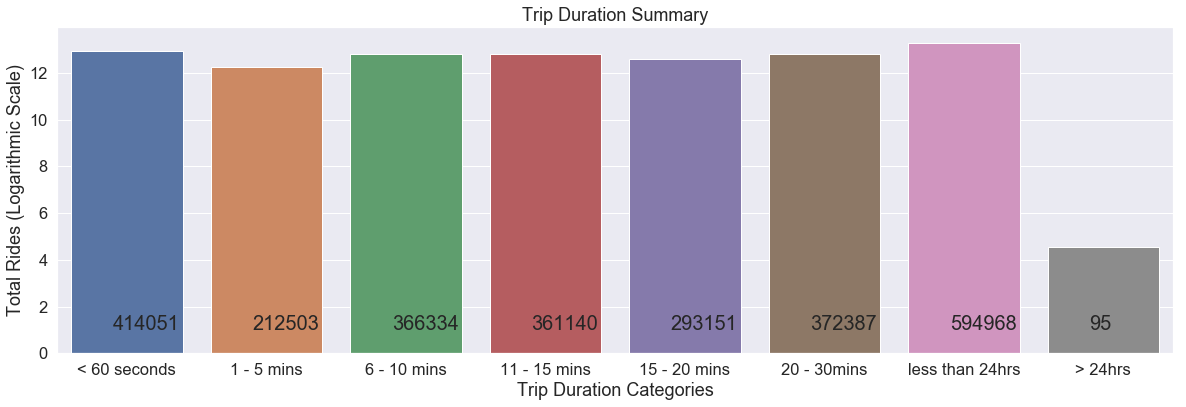

In [45]:
# dockless_data['Trip Duration'].max() -- 1888695.0
# dockless_data['Trip Duration'].min() -- -431.0
dd = pd.DataFrame({'trip_duration':trip_distance_value_count.index, 'count':trip_distance_value_count.values})

bins = [-431.0, 60, 300, 600,900, 1200, 1800, 86400, 1888695]
labels = ['< 60 seconds', '1 - 5 mins','6 - 10 mins' ,'11 - 15 mins', '15 - 20 mins', '20 - 30mins', 'less than 24hrs', '> 24hrs']
dd['category_classes'] = pd.cut(dd['trip_duration'], bins=bins, labels=labels,include_lowest=True, right=True)
prob_groups = dd.groupby(['category_classes'])['count'].sum()

prob_groups_log = np.log(prob_groups)

plt.figure(figsize=(20,6))

# sns.barplot(x=prob_groups.index, y=prob_groups.values)
# plt.title('Trip Duration Summary', fontsize=25)
# plt.ylabel('Scooter count', fontsize=20)
# plt.xlabel('Trip Duration Categories', fontsize=20)
# plt.savefig('../../output/Final/Trip_Duration_Summary.png')

sns.barplot(x=prob_groups_log.index, y=prob_groups_log.values)

for i in range(len(prob_groups)):
    plt.text(x=i-0.1, y=1 ,s = prob_groups[i], size = 20)
plt.title('Trip Duration Summary')
plt.ylabel('Total Rides (Logarithmic Scale)')
plt.xlabel('Trip Duration Categories')
plt.savefig('../../output/Final/Trip_Duration_Log_Scale_Summary.png')

plt.show()

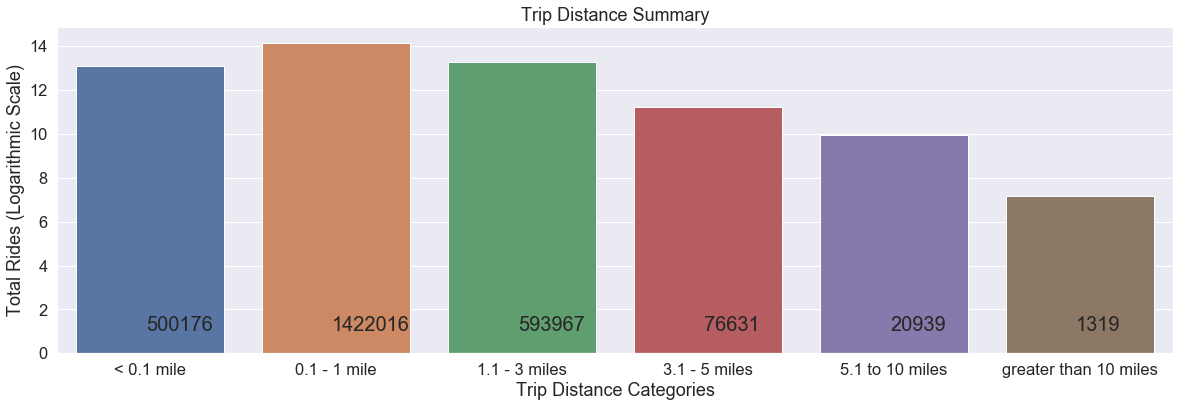

In [46]:
# dockless_data['Trip Distance'].max() -- 2147479547.0
# dockless_data['Trip Distance'].min() -- -16724106.0

dd = pd.DataFrame({'trip_distance':trip_distance_value_count.index, 'count':trip_distance_value_count.values})

bins2 = [-16724106.0, 161, 1601, 4828,8047, 16093, 804672]
labels2 = ['< 0.1 mile', '0.1 - 1 mile','1.1 - 3 miles' ,'3.1 - 5 miles', '5.1 to 10 miles', 'greater than 10 miles']
dd['category_classes'] = pd.cut(dd['trip_distance'], bins=bins2, labels=labels2, include_lowest=True, right=True)

prob_groups = dd.groupby(['category_classes'])['count'].sum()

prob_groups_log = np.log(prob_groups)

plt.figure(figsize=(20,6))

# sns.barplot(x=prob_groups.index, y=prob_groups.values)
# plt.title('Trip Distance Summary')
# plt.ylabel('Scooter count')
# plt.xlabel('Trip Distance Categories')
# plt.savefig('../../output/Final/Trip_Distance_Summary.png')

sns.barplot(x=prob_groups_log.index, y=prob_groups_log.values)

for i in range(len(prob_groups)):
    plt.text(x=i-0.02, y=1 ,s = prob_groups[i], size = 20)


plt.title('Trip Distance Summary')
plt.ylabel('Total Rides (Logarithmic Scale)')
plt.xlabel('Trip Distance Categories')
plt.savefig('../../output/Final/Trip_Distance_Log_Scale_Summary.png')

plt.show()


##### Data Cleaning.

Data is self-reported so it is all over the place. I have used the same criteria for filtering the trips as City of Austin open data portal website. The weather data is also changed to have the same start and end dates as the trip information

In [5]:

# Drop all records where  trip distance is less .1 miles and greater than 500 miles (160.934 mts - 804673 mts)
dockless_data = dockless_data[(dockless_data['Trip Distance'] > 160.934) & (dockless_data['Trip Distance'] < 804673)]
dockless_data = dockless_data[(dockless_data['Trip Duration'] > 60) & (dockless_data['Trip Duration'] < 86400)]

In [6]:

# Have only weather data which is from the start date of the scooter data
trip_counts = dockless_data.groupby('START_DATE').count()['count']
weather_data= weather_data[weather_data['DATE'] >= trip_counts.index.min()]
weather_data= weather_data[weather_data['DATE'] <= trip_counts.index.max()]


#### Timestamp Timestamp('2018-04-03 18:30:00') - min and Timestamp('2019-02-12 06:15:00') - max

In [7]:
total_trip_counts = dockless_data.groupby('Start Time').count()['count']

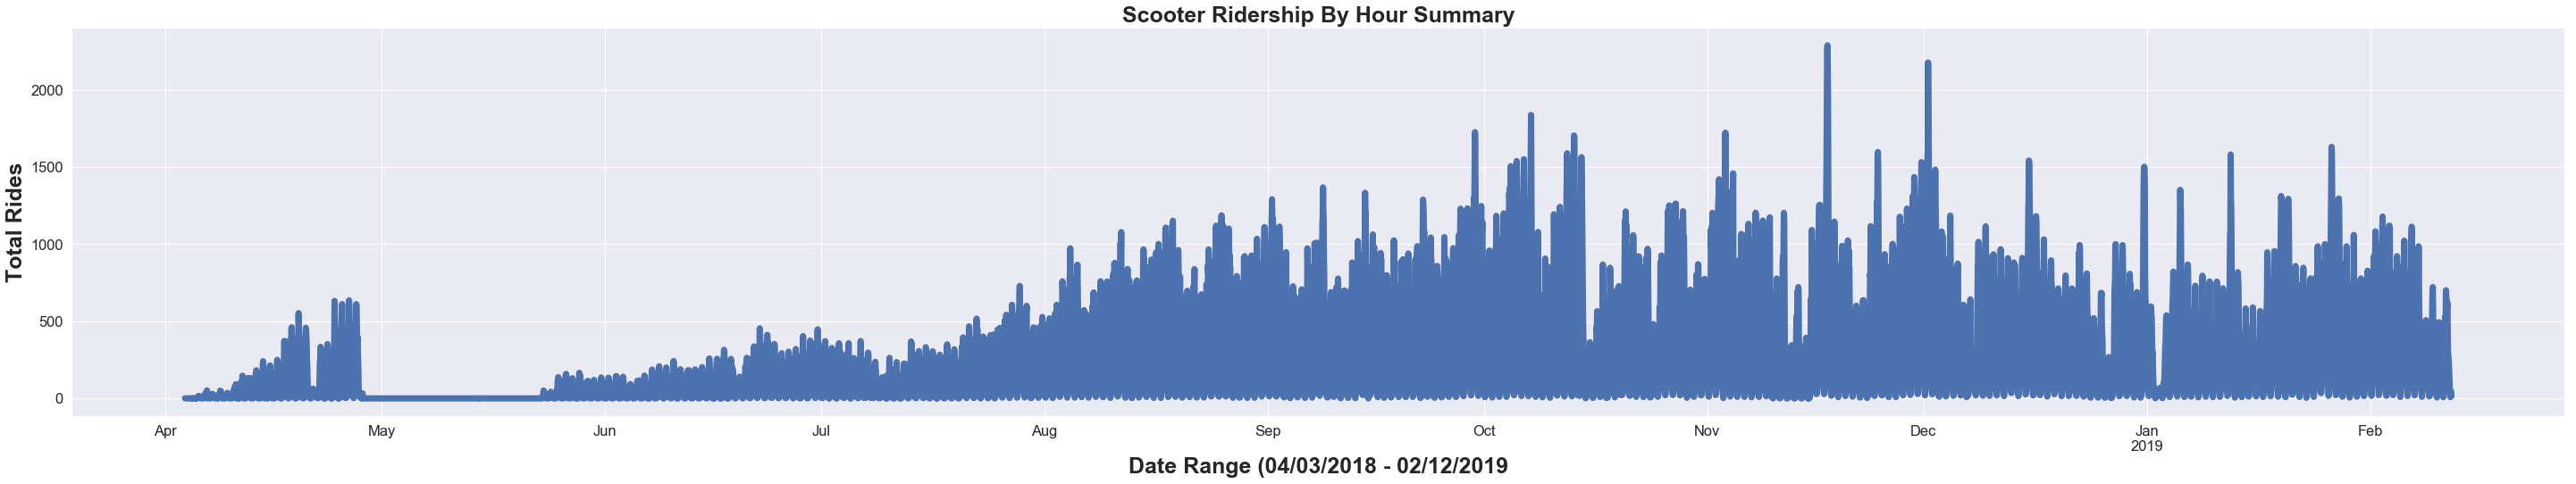

In [8]:
hourly = total_trip_counts.resample('H').sum()
hourly.plot(style=['-', '--', ':'],figsize=(50, 8),linewidth=7.0)
plt.title('Scooter Ridership By Hour Summary',fontsize=25,fontweight='bold')
plt.ylabel('Total Rides',fontsize=25,fontweight='bold')
plt.xlabel("Date Range (04/03/2018 - 02/12/2019",fontsize=25,fontweight='bold')
plt.savefig('../../output/Final/Scooter_Ridership_By_Hour_Summary.png')

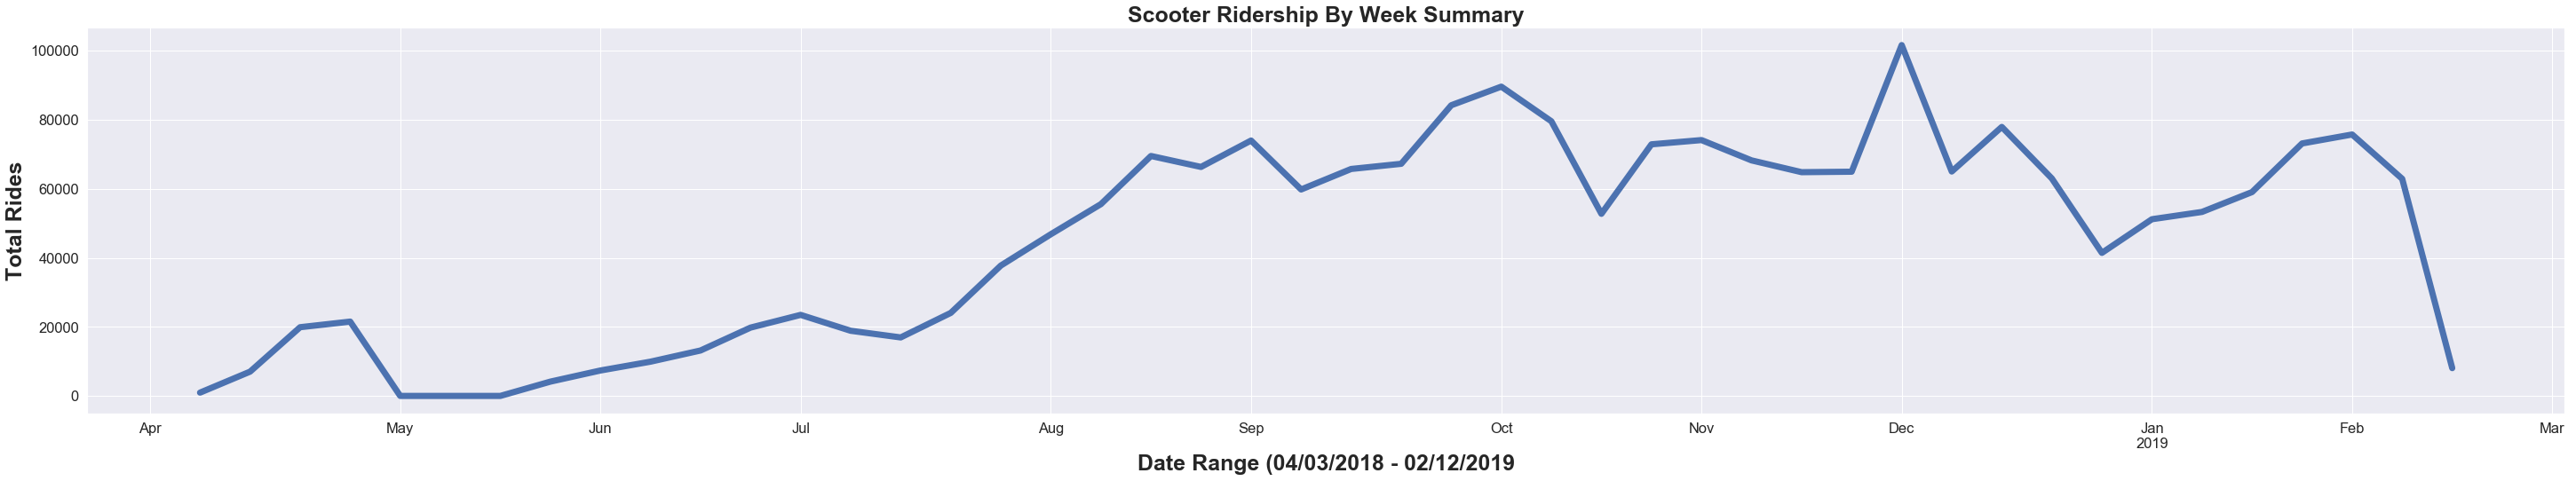

In [9]:
hourly = total_trip_counts.resample('W').sum()
hourly.plot(style=['-', '--', ':'],figsize=(50, 8),linewidth=7.0)
plt.title('Scooter Ridership By Week Summary',fontsize=25,fontweight='bold')
plt.ylabel('Total Rides',fontsize=25,fontweight='bold')
plt.xlabel("Date Range (04/03/2018 - 02/12/2019",fontsize=25,fontweight='bold')
plt.savefig('../../output/Final/Scooter_Ridership_By_Week_Summary.png')

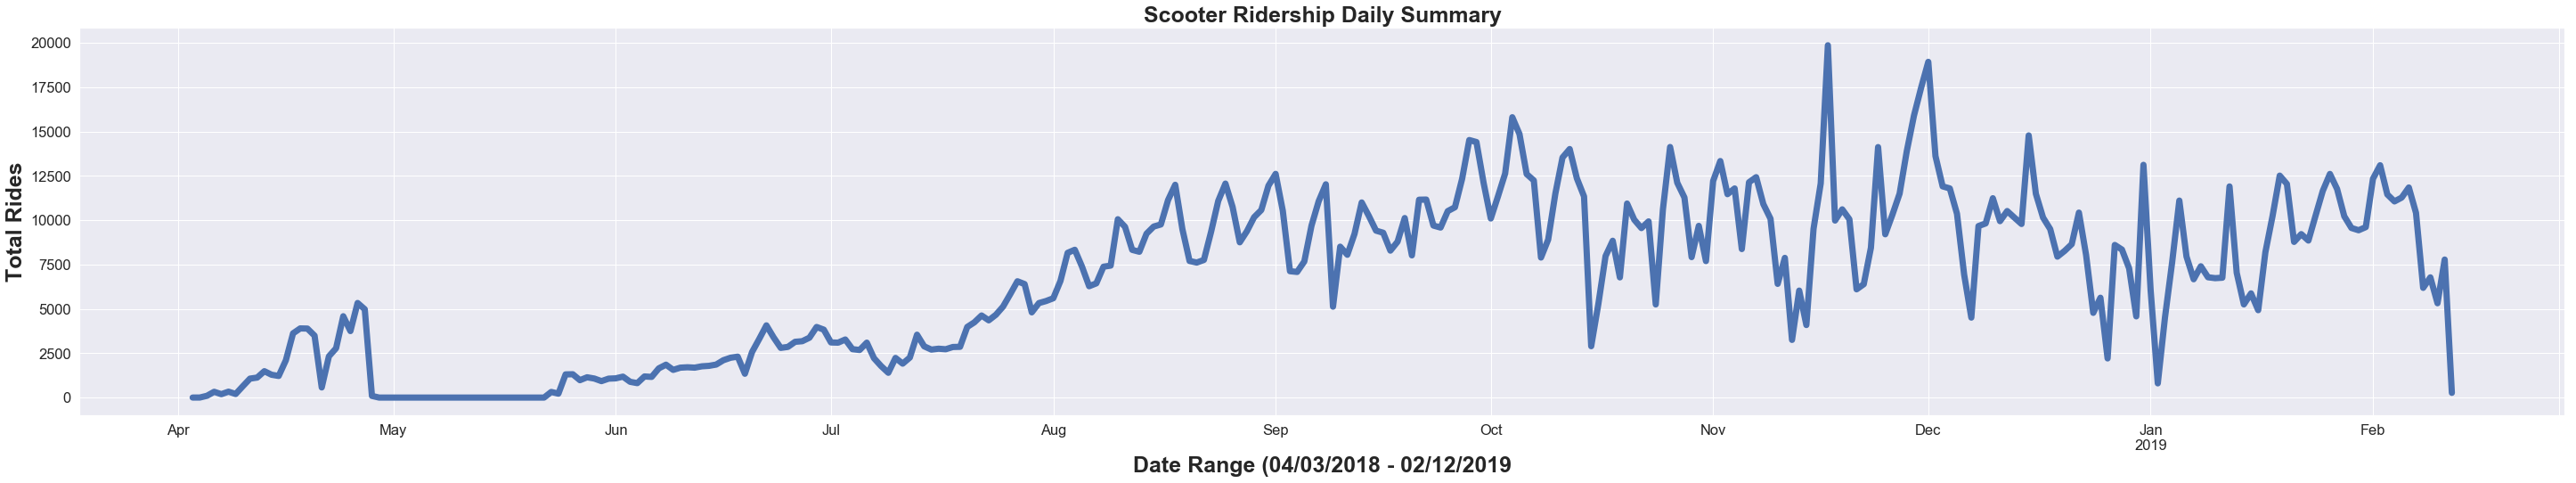

In [10]:
hourly = total_trip_counts.resample('D').sum()
hourly.plot(style=['-', '--', ':'],figsize=(50, 8),linewidth=7.0)
plt.title('Scooter Ridership Daily Summary',fontsize=25,fontweight='bold')
plt.ylabel('Total Rides',fontsize=25,fontweight='bold')
plt.xlabel("Date Range (04/03/2018 - 02/12/2019",fontsize=25,fontweight='bold')
plt.savefig('../../output/Final/Scooter_Ridership_Daily_Summary.png')

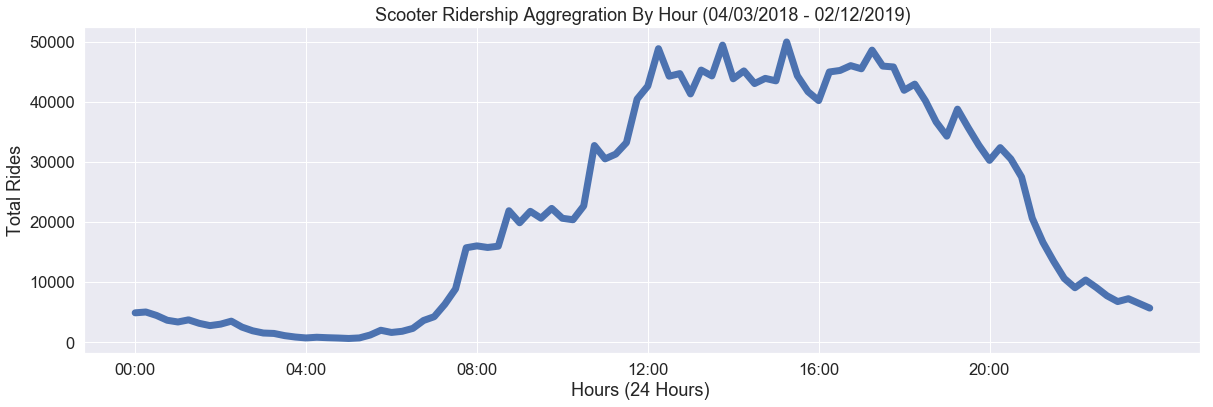

In [11]:
by_time = total_trip_counts.groupby(total_trip_counts.index.time).sum()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=['-', '--', ':'],figsize=(20, 6),linewidth=7.0);
plt.title('Scooter Ridership Aggregration By Hour (04/03/2018 - 02/12/2019)')
plt.ylabel('Total Rides')
plt.xlabel("Hours (24 Hours) ")
#plt.xlabel('Month', fontsize=12,rotation='horizontal')
#plt.xticks(rotation=90)
plt.savefig('../../output/Final/Scooter_Ridership_Aggregration_By_Hour.png')
plt.show()

In [12]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316 entries, 92 to 407
Data columns (total 7 columns):
DATE                    316 non-null object
AVG_DAILY_WIND_SPEED    316 non-null float64
PRECIPITATION           316 non-null float64
SNOW                    316 non-null float64
AVG_TEMPERATURE         316 non-null float64
MAX_TEMPERATURE         316 non-null float64
MIN_TEMPERATURE         316 non-null float64
dtypes: float64(6), object(1)
memory usage: 19.8+ KB


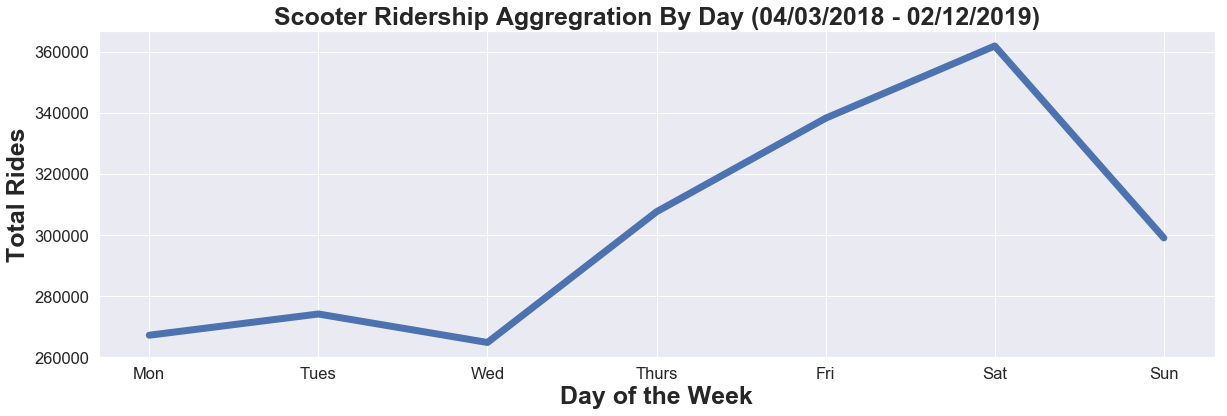

In [13]:
#fig.set_size_inches(18.5, 10.5, forward=True)
by_weekday = total_trip_counts.groupby(total_trip_counts.index.dayofweek).sum()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', '--', ':'],figsize=(20, 6),linewidth=7.0);
plt.title('Scooter Ridership Aggregration By Day (04/03/2018 - 02/12/2019)',fontsize=25,fontweight='bold')
plt.ylabel('Total Rides',fontsize=25,fontweight='bold')
plt.xlabel('Day of the Week',rotation='horizontal',fontsize=25,fontweight='bold')
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'))
#plt.xticks(rotation=90)
plt.savefig('../../output/Final/Day_of_Week_Ridership_Summary.png')
plt.show()

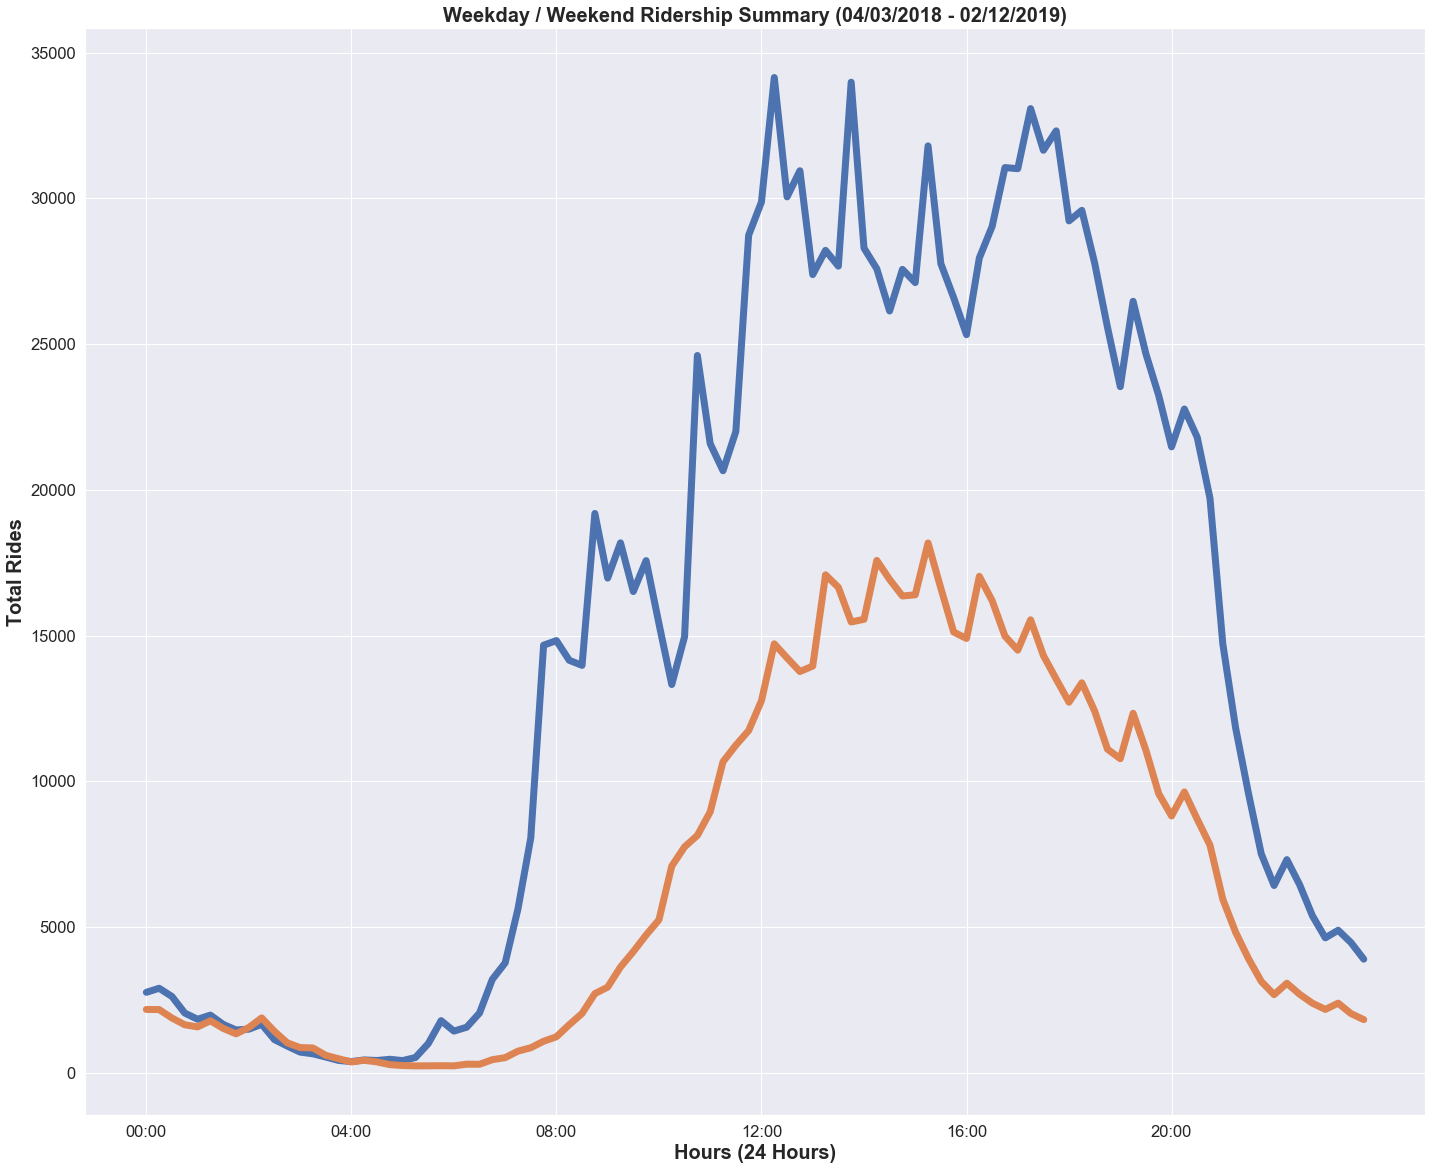

In [78]:
'''
This shows a strong distinction between weekday and weekend totals, 
with around twice as many average riders crossing the bridge on Monday through Friday than on Saturday and Sunday.

With this in mind, let's do a compound GroupBy and look at the hourly trend on weekdays versus weekends. 
We'll start by grouping by both a flag marking the weekend, and the time of day:
'''
weekend = np.where(total_trip_counts.index.weekday < 5, 'Weekday', 'Weekend')
by_time = total_trip_counts.groupby([weekend, total_trip_counts.index.time]).sum()

#plt.subplots_adjust(bottom = 1.1,top = 1.9,wspace = 0.2,hspace = 0.2)

fig, ax = plt.subplots(1, 1, figsize=(24, 20))
ax = by_time.loc['Weekday'].plot(title='Weekday Ridership Summary (04/03/2018 - 02/12/2019)', linewidth=7.0,
                           xticks=hourly_ticks, style=['-', '--', ':'])
ax = by_time.loc['Weekend'].plot(title='Weekday / Weekend Ridership Summary (04/03/2018 - 02/12/2019)',linewidth=7.0,
                           xticks=hourly_ticks, style=['-', '--', ':']);
# ax2 = by_time.loc['Weekend'].plot(ax=ax[1], title='Weekend Ridership Summary (04/03/2018 - 02/12/2019)',
#                            xticks=hourly_ticks, style=['-', '--', ':']);

ax.set_title("Weekday / Weekend Ridership Summary (04/03/2018 - 02/12/2019)",fontsize=20,fontweight='bold')
ax.set_xlabel("Hours (24 Hours)",fontsize=20,fontweight='bold')
ax.set_ylabel("Total Rides",fontsize=20,fontweight='bold')
# ax2.set_xlabel("Hours (24 Hours)")
# ax2.set_ylabel("Total Rides")
plt.savefig('../../output/Final/Weekday_Weekend_Ridership.png')
plt.show()

In [15]:
daily = total_trip_counts.resample('D').sum()

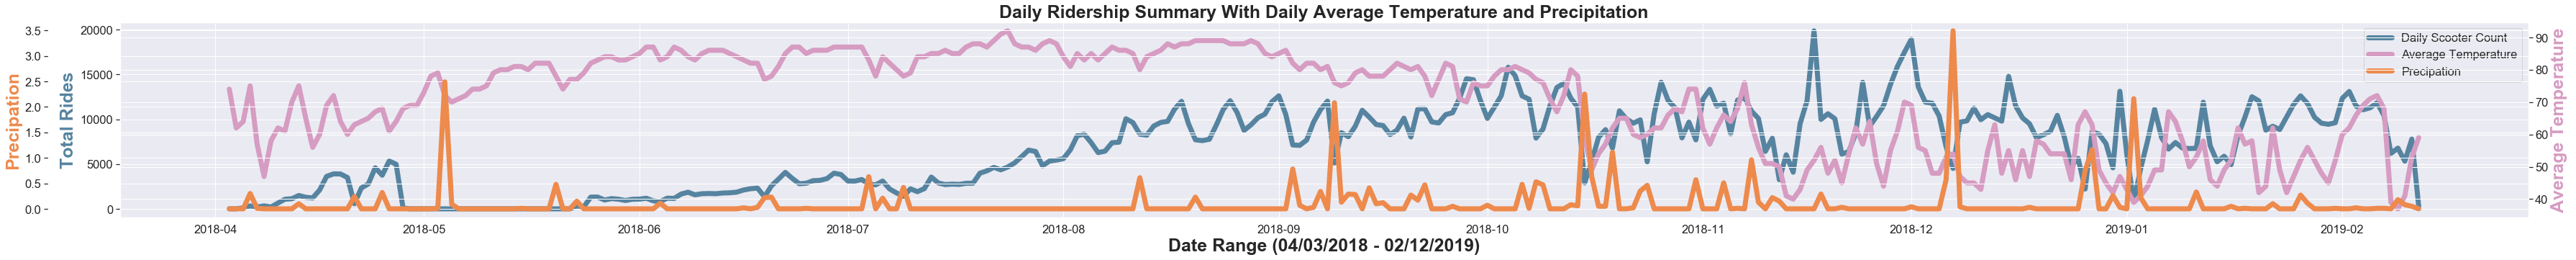

In [24]:

fig, ax = plt.subplots(figsize=(60,5))

par1 = ax.twinx()
par2 = ax.twinx()

offset = 60
color1 = "#5684A0"
color2 = "#D69CC2"
color3 = "#ED8A4C"


#flatui = ["#5684A0", "#3498db","#9b59b6","#2ecc71" ,"#C93551", "#7EC581", "#D69CC2", "#BEC45F","#FCC38E", "#ED8A4C", "#997474","#8B878D"]
#sns.palplot(sns.color_palette(flatui))
# flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# sns.palplot(sns.color_palette(flatui))


par1.set_ylabel("Temperature")
par2.set_ylabel("Precipation")

par2.spines['left'].set_position(('outward', 100)) 
par2.spines["left"].set_visible(True) 
par2.yaxis.set_label_position('left') 
par2.yaxis.set_ticks_position('left')

p1, = ax.plot(daily.index, daily.values, color=color1, label="Daily Scooter Count",linewidth=7.0,)
p2, = par1.plot(weather_data.DATE, weather_data.AVG_TEMPERATURE.values,color=color2,linewidth=7.0, label="Average Temperature")
p3, = par2.plot(weather_data.DATE, weather_data.PRECIPITATION.values,color=color3, linewidth=7.0, label="Precipation")

lns = [p1, p2, p3]
ax.legend(handles=lns, loc='best')


par2.spines['right'].set_position(('outward', 60)) 

ax.set_ylabel('Total Rides', color=color1,fontsize=25,fontweight='bold')
par1.set_ylabel('Average Temperature', color=color2,fontsize=25,fontweight='bold')
par2.set_ylabel('Precipation', color=color3,fontsize=25,fontweight='bold')

plt.title('Daily Ridership Summary With Daily Average Temperature and Precipitation',fontsize=25,fontweight='bold')
ax.set_xlabel('Date Range (04/03/2018 - 02/12/2019)',fontsize=25,fontweight='bold')

plt.savefig("../../output/Final/Ridership_Temperature_Precipitation.png")
plt.show()

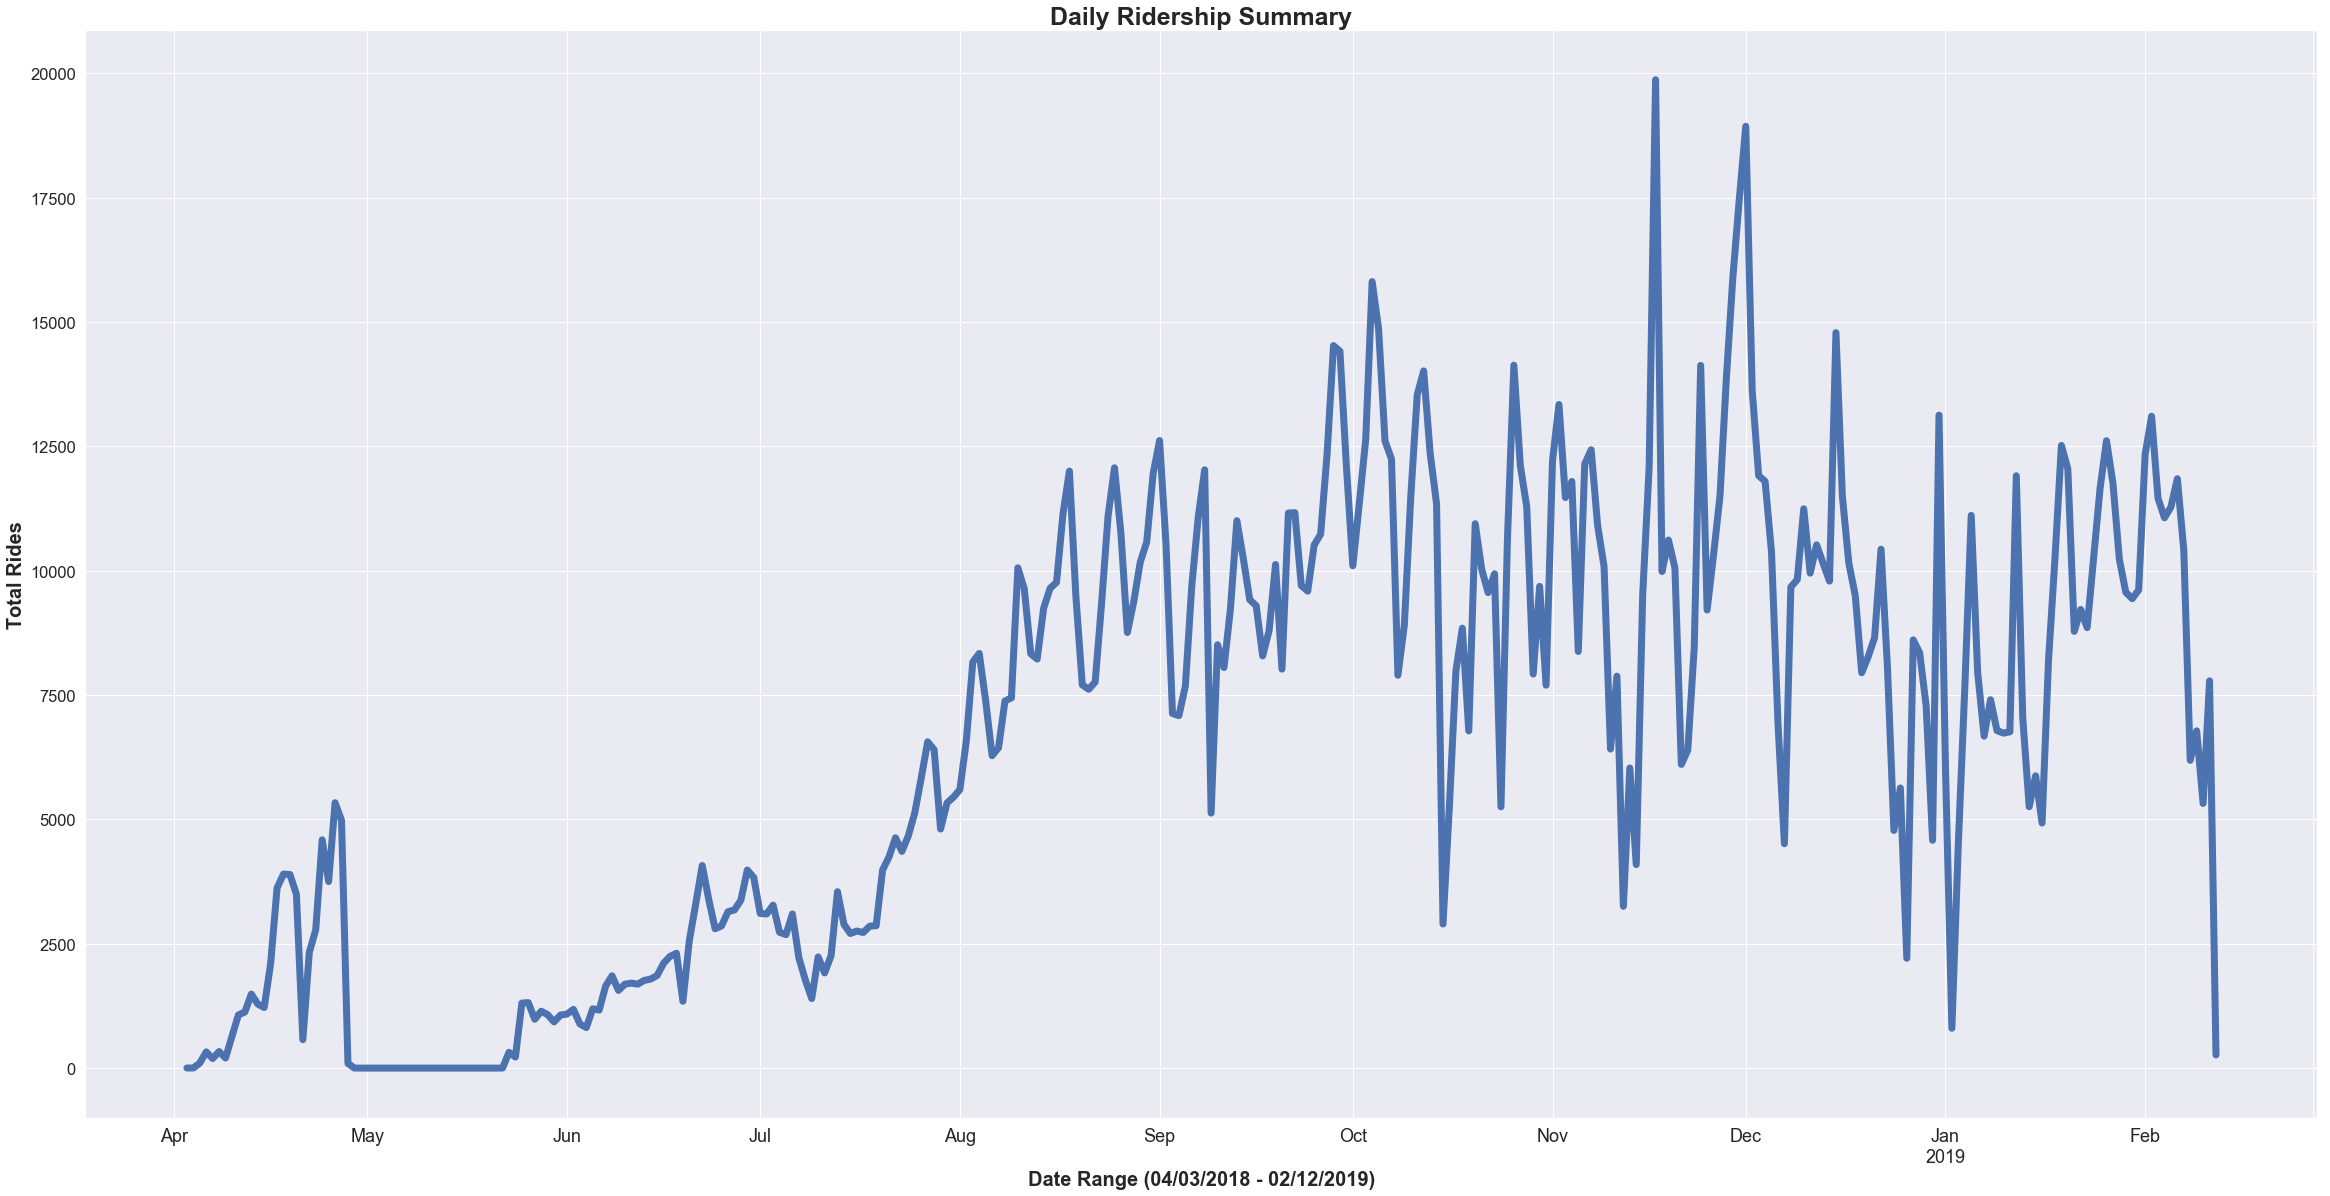

In [25]:
daily = total_trip_counts.resample('D').sum()
daily.plot(style=['-', '--', ':'],figsize=(40, 20), linewidth=7.0)
plt.title('Daily Ridership Summary',fontsize=25,fontweight='bold')
plt.ylabel("Total Rides",fontsize=20,fontweight='bold')
plt.xlabel('Date Range (04/03/2018 - 02/12/2019)',fontsize=20,fontweight='bold')
plt.xticks(fontsize=18)
plt.savefig('../../output/Final/Daily_Ridership_Summary.png')

In [26]:
nov_15_dec_15 = dockless_data[(dockless_data.index >= '2018-11-30')]
nov_15_dec_15 = nov_15_dec_15[(nov_15_dec_15.index <= '2018-12-10')]

start_date = dt.date(2018,11,30)
end_date = dt.date(2018,12,10)

weather_data_nov_15_dec_15 = weather_data[(weather_data.DATE >= start_date) & (weather_data.DATE <= end_date)]

nov_15_dec_15_daily = nov_15_dec_15.resample('D').sum()
count_nov_15_dec_15_daily = nov_15_dec_15_daily['count']

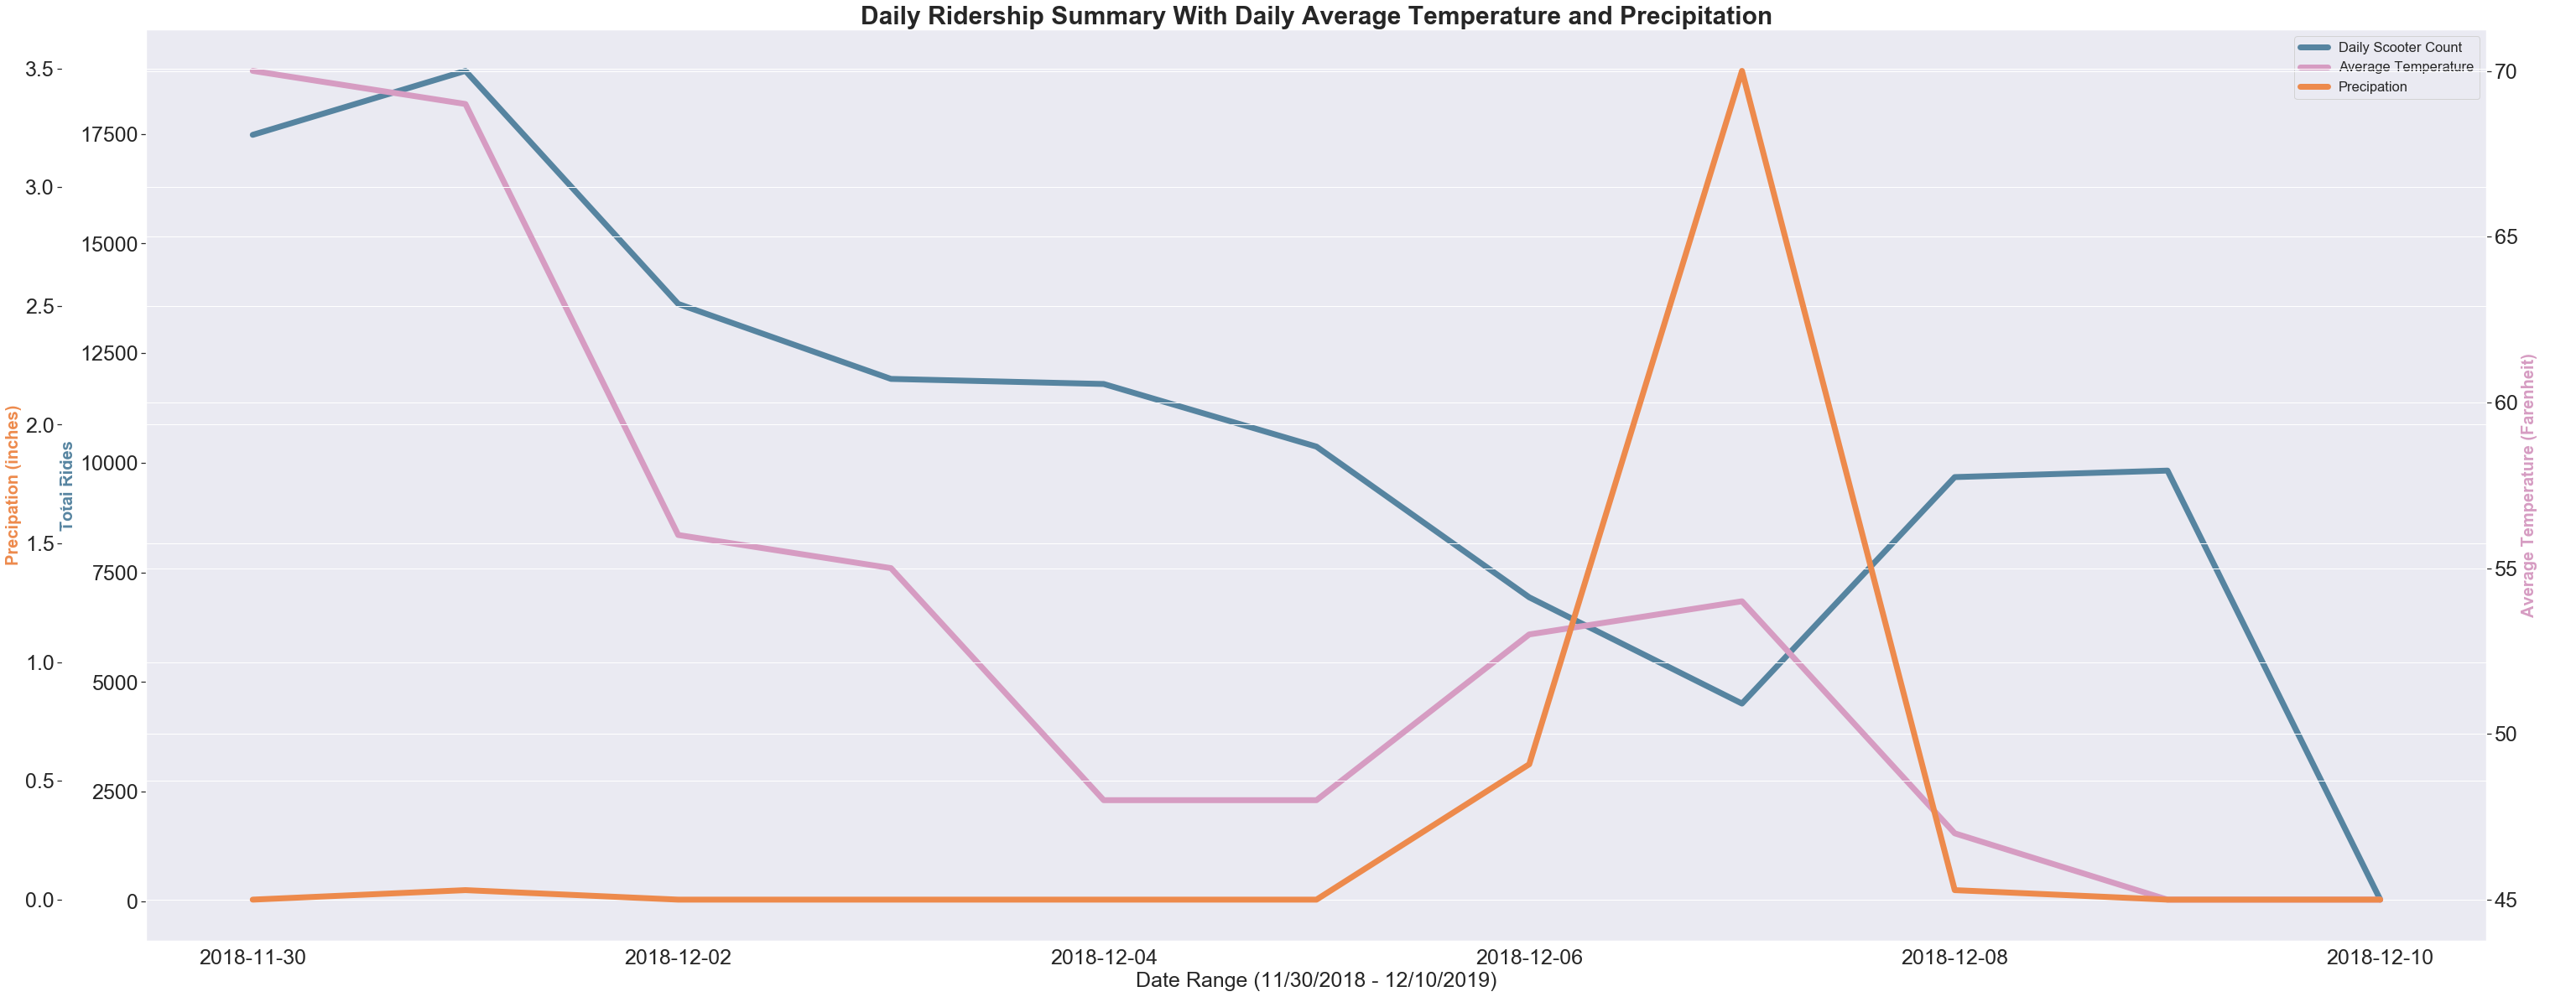

In [86]:
# Plot only subsection of the data

# from mpl_toolkits.axes_grid1 import host_subplot
# import mpl_toolkits.axisartist as AA
# import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(50,20))

ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)

plt.grid(b=None)
par1 = ax.twinx()
par2 = ax.twinx()

par1.tick_params(axis='both', which='major', labelsize=25)
par1.tick_params(axis='both', which='minor', labelsize=25)

par2.tick_params(axis='both', which='major', labelsize=25)
par2.tick_params(axis='both', which='minor', labelsize=25)

offset = 80

color1 = "#5684A0"
color2 = "#D69CC2"
color3 = "#ED8A4C"


flatui = ["#5684A0", "#3498db","#9b59b6","#2ecc71" ,"#C93551", "#7EC581", "#D69CC2", "#BEC45F","#FCC38E", "#ED8A4C", "#997474","#8B878D"]
#sns.palplot(sns.color_palette(flatui))
# flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# sns.palplot(sns.color_palette(flatui))

par1.set_ylabel("Temperature")
par2.set_ylabel("Precipation")

par2.spines['left'].set_position(('outward', 100)) 
par2.spines["left"].set_visible(True) 
par2.yaxis.set_label_position('left') 
par2.yaxis.set_ticks_position('left')

p1, = ax.plot(nov_15_dec_15_daily.index, count_nov_15_dec_15_daily, color=color1, linewidth=7.0, label="Daily Scooter Count")
p2, = par1.plot(weather_data_nov_15_dec_15.DATE, weather_data_nov_15_dec_15.AVG_TEMPERATURE.values, linewidth=7.0, color=color2, label="Average Temperature")
p3, = par2.plot(weather_data_nov_15_dec_15.DATE, weather_data_nov_15_dec_15.PRECIPITATION.values,linewidth=7.0, color=color3,  label="Precipation")

lns = [p1, p2, p3]
ax.legend(handles=lns, loc='best')

par2.spines['right'].set_position(('outward', 100)) 

ax.set_ylabel('Total Rides', color=color1,fontsize=20,fontweight='bold')
par1.set_ylabel('Average Temperature (Farenheit)', color=color2, fontsize=20,fontweight='bold')
par2.set_ylabel('Precipation (inches)', color=color3,fontsize=20,fontweight='bold')

plt.title('Daily Ridership Summary With Daily Average Temperature and Precipitation',fontweight='bold',fontsize=30)
ax.set_xlabel('Date Range (11/30/2018 - 12/10/2019)',fontsize=25)

plt.savefig("../../output/Final/Ridership_Temperature_Precipitation_11_30_to_12_10.png")
plt.show()



#### Chi-Squared Test for UT cell and Downtown cell

In [28]:
# CHI-SQUARED TEST

downtown_6_congress_cell_data_hour = prepare_cell_data(dockless_data, weather_data, "014707")
ut_greogory_gym_cell_data_hour = prepare_cell_data(dockless_data, weather_data, "015029")

hours=[0, 6, 10, 15, 19, 23]


down_town_counts = downtown_6_congress_cell_data_hour[['Trip Counts']]
down_town_counts['HOUR'] = pd.DatetimeIndex(down_town_counts.index).hour
down_town_counts['HOUR_LABEL'] = pd.cut(down_town_counts['HOUR'], hours, include_lowest=True, right=True, labels=['0', '1', '2', '3', '4'])
down_town_counts.drop(['HOUR'], axis=1, inplace=True)
downtown_counts = (down_town_counts.groupby('HOUR_LABEL').sum())['Trip Counts']

ut_greogory_gym_cell_data_counts = ut_greogory_gym_cell_data_hour[['Trip Counts']]
ut_greogory_gym_cell_data_counts['HOUR'] = pd.DatetimeIndex(ut_greogory_gym_cell_data_counts.index).hour
ut_greogory_gym_cell_data_counts['HOUR_LABEL'] = pd.cut(ut_greogory_gym_cell_data_counts['HOUR'], hours, include_lowest=True, right=True, labels=['0', '1', '2', '3', '4'])
ut_greogory_gym_cell_data_counts.drop(['HOUR'], axis=1, inplace=True)
ut_counts = (ut_greogory_gym_cell_data_counts.groupby('HOUR_LABEL').sum())['Trip Counts']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata

In [29]:
mae = np.array([4.121601, 3.6985, 3.6452, 3.1511, 5.3672,3.4769, 3.2778, 2.7182, 5.3105])
mae.mean()

3.863000111111111

In [46]:

# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
table = [[658, 3690, 17517,12984,3660],[184,5028,12787,5527,1486]]
print("contingency table")
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('degrees of freedom = %d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

contingency table
[[658, 3690, 17517, 12984, 3660], [184, 5028, 12787, 5527, 1486]]
degrees of freedom = 4
[[  510.45446388  5285.20429464 18371.51077596 11222.11707939
   3119.71338612]
 [  331.54553612  3432.79570536 11932.48922404  7288.88292061
   2026.28661388]]
probability=0.950, critical=9.488, stat=2372.138
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [40]:
# CHI-SQUARED TEST

downtown_6_congress_cell_data_hour = prepare_cell_data(dockless_data, weather_data, "014707")
brazos_Ceaser_chavez_data_hour = prepare_cell_data(dockless_data, weather_data, "014706")

hours=[0, 6, 10, 15, 19, 23]


down_town_counts = downtown_6_congress_cell_data_hour[['Trip Counts']]
down_town_counts['HOUR'] = pd.DatetimeIndex(down_town_counts.index).hour
down_town_counts['HOUR_LABEL'] = pd.cut(down_town_counts['HOUR'], hours, include_lowest=True, right=True, labels=['0', '1', '2', '3', '4'])
down_town_counts.drop(['HOUR'], axis=1, inplace=True)
downtown_counts = (down_town_counts.groupby('HOUR_LABEL').sum())['Trip Counts']

brazos_Ceaser_chavez_data_counts = brazos_Ceaser_chavez_data_hour[['Trip Counts']]
brazos_Ceaser_chavez_data_counts['HOUR'] = pd.DatetimeIndex(brazos_Ceaser_chavez_data_counts.index).hour
brazos_Ceaser_chavez_data_counts['HOUR_LABEL'] = pd.cut(brazos_Ceaser_chavez_data_counts['HOUR'], hours, include_lowest=True, right=True, labels=['0', '1', '2', '3', '4'])
brazos_Ceaser_chavez_data_counts.drop(['HOUR'], axis=1, inplace=True)
brazos_Ceaser_counts = (brazos_Ceaser_chavez_data_counts.groupby('HOUR_LABEL').sum())['Trip Counts']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata

In [41]:
downtown_counts

HOUR_LABEL
0      658
1     3690
2    17517
3    12894
4     3660
Name: Trip Counts, dtype: int64

In [42]:
brazos_Ceaser_counts

HOUR_LABEL
0      772
1     3920
2    16714
3    14558
4     4424
Name: Trip Counts, dtype: int64

In [45]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
table = [[658, 3690, 17517,12984,3660],[772,3920,16714,14558,4424]]
print("contingency table")
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('degrees of freedom = %d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

contingency table
[[658, 3690, 17517, 12984, 3660], [772, 3920, 16714, 14558, 4424]]
degrees of freedom = 4
[[  697.97165925  3714.38064819 16707.87962787 13443.03177561
   3945.73628909]
 [  732.02834075  3895.61935181 17523.12037213 14098.96822439
   4138.26371091]]
probability=0.950, critical=9.488, stat=152.369
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [ ]:
twosample_results = scipy.stats.ttest_ind(data1, data2)

matrix_twosample = [
    ['', 'Test Statistic', 'p-value'],
    ['Sample Data', twosample_results[0], twosample_results[1]]
]

twosample_table = FF.create_table(matrix_twosample, index=True)
py.iplot(twosample_table, filename='twosample-table')

In [55]:
dec_2_dec_4

,Trip Counts,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,HOUR_LABEL,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE
Start Time,,,,,,,,,,,,,,,,
2018-12-02 00:00:00,3,12,2018,0,2,48,6,1.0,0.0,0,7.83,0.0,0.0,56.0,70.0,40.0
2018-12-02 01:00:00,2,12,2018,1,2,48,6,1.0,0.0,0,7.83,0.0,0.0,56.0,70.0,40.0
2018-12-02 02:00:00,0,12,2018,2,2,48,6,1.0,0.0,0,7.83,0.0,0.0,56.0,70.0,40.0
2018-12-02 03:00:00,0,12,2018,3,2,48,6,1.0,0.0,0,7.83,0.0,0.0,56.0,70.0,40.0
2018-12-02 04:00:00,0,12,2018,4,2,48,6,1.0,0.0,0,7.83,0.0,0.0,56.0,70.0,40.0
2018-12-02 05:00:00,0,12,2018,5,2,48,6,1.0,0.0,0,7.83,0.0,0.0,56.0,70.0,40.0
2018-12-02 06:00:00,0,12,2018,6,2,48,6,1.0,0.0,0,7.83,0.0,0.0,56.0,70.0,40.0
2018-12-02 07:00:00,0,12,2018,7,2,48,6,1.0,0.0,1,7.83,0.0,0.0,56.0,70.0,40.0
2018-12-02 08:00:00,1,12,2018,8,2,48,6,1.0,0.0,1,7.83,0.0,0.0,56.0,70.0,40.0


In [51]:
# 12/6 - 12/8 Thursday - Friday (Rainy day) vs ( 12/2 - 12/4 non -rainy days)

dec_6_dec_8 = dockless_data[(dockless_data.index >= '2018-12-07')]
dec_6_dec_8 = dec_6_dec_8[(dec_6_dec_8.index < '2018-12-08')]

dec_2_dec_4 = dockless_data[(dockless_data.index >= '2018-12-02')]
dec_2_dec_4 = dec_2_dec_4[(dec_2_dec_4.index <= '2018-12-04')]

In [84]:
dec_6_dec_8 = downtown_6_congress_cell_data_hour[(downtown_6_congress_cell_data_hour.index >= '2018-12-06')]
dec_6_dec_8 = dec_6_dec_8[(dec_6_dec_8.index <= '2018-12-08')]

dec_2_dec_4 = downtown_6_congress_cell_data_hour[(downtown_6_congress_cell_data_hour.index >= '2018-12-02')]
dec_2_dec_4 = dec_2_dec_4[(dec_2_dec_4.index <= '2018-12-04')]

In [85]:
dec6_dec_8_counts = dec_6_dec_8['Trip Counts']
dec_2_dec_4_counts = dec_2_dec_4['Trip Counts']

twosample_results = ttest_ind(dec6_dec_8_counts, dec_2_dec_4_counts)

twosample_results

Ttest_indResult(statistic=-2.7491611173241775, pvalue=0.007139343170825304)

In [80]:
dec_2_dec_4_counts.mean()

7.4

In [81]:
dec6_dec_8_counts.mean()

2.48

In [82]:
twosample_results = ttest_ind(7.4, 2.48)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [83]:
twosample_results

Ttest_indResult(statistic=nan, pvalue=nan)